# [**Imputation des valeurs manquantes avant la construction d'un estimateur**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/6_4_impute/plot_missing_values.ipynb)<br/>([_Imputing missing values before building an estimator_](https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html))

Les valeurs manquantes peuvent être remplacées par la moyenne, la médiane ou la valeur la plus fréquente en utilisant le [**`SimpleImputer`**](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) de base.

Dans cet exemple, nous allons étudier différentes techniques d'imputation :
- Imputation par la valeur constante 0
- Imputation par la valeur moyenne de chaque caractéristique combinée avec une variable auxiliaire indiquant l'absence de valeur manquante
- Imputation par les k plus proches voisins
- Imputation itérative

Nous utiliserons deux ensembles de données : l'ensemble de données sur le diabète, qui comprend 10 variables de caractéristiques recueillies auprès de patients atteints de diabète dans le but de prédire l'évolution de la maladie, et l'ensemble de données sur le logement en Californie, pour lequel la cible est la valeur médiane des maisons dans les districts californiens.

Comme aucun de ces ensembles de données ne contient de valeurs manquantes, nous supprimerons certaines valeurs pour créer de nouvelles versions avec des données artificiellement manquantes. Les performances du [**`RandomForestRegressor`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) sur l'ensemble de données original complet sont ensuite comparées aux performances sur les ensembles de données modifiés avec les valeurs manquantes artificiellement imputées en utilisant différentes techniques.

In [ ]:
# Authors: Maria Telenczuk  <https://github.com/maikia>
# License: BSD 3 clause

# Téléchargez les données et créez des ensembles de valeurs manquantes

Tout d'abord, nous téléchargeons les deux ensembles de données. L'ensemble de données sur le diabète est inclus dans la bibliothèque scikit-learn. Il contient 442 entrées, chacune avec 10 caractéristiques. L'ensemble de données sur le logement en Californie est beaucoup plus volumineux avec 20640 entrées et 8 caractéristiques. Il doit être téléchargé. Nous n'utiliserons que les 400 premières entrées pour accélérer les calculs, mais n'hésitez pas à utiliser l'ensemble de données complet.

In [1]:
import numpy as np

from sklearn.datasets import fetch_california_housing
from sklearn.datasets import load_diabetes


rng = np.random.RandomState(42)

X_diabetes, y_diabetes = load_diabetes(return_X_y=True)
X_california, y_california = fetch_california_housing(return_X_y=True)
X_california = X_california[:300]
y_california = y_california[:300]
X_diabetes = X_diabetes[:300]
y_diabetes = y_diabetes[:300]


def add_missing_values(X_full, y_full):
    n_samples, n_features = X_full.shape

    # Add missing values in 75% of the lines
    missing_rate = 0.75
    n_missing_samples = int(n_samples * missing_rate)

    missing_samples = np.zeros(n_samples, dtype=bool)
    missing_samples[:n_missing_samples] = True

    rng.shuffle(missing_samples)
    missing_features = rng.randint(0, n_features, n_missing_samples)
    X_missing = X_full.copy()
    X_missing[missing_samples, missing_features] = np.nan
    y_missing = y_full.copy()

    return X_missing, y_missing


X_miss_california, y_miss_california = add_missing_values(X_california, y_california)

X_miss_diabetes, y_miss_diabetes = add_missing_values(X_diabetes, y_diabetes)

# Imputer les données manquantes et évaluer

Maintenant, nous allons écrire une fonction qui évaluera les résultats sur les données imputées de différentes manières. Examinons chaque imputeur séparément :

In [2]:
rng = np.random.RandomState(0)

from sklearn.ensemble import RandomForestRegressor

# To use the experimental IterativeImputer, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline


N_SPLITS = 4
regressor = RandomForestRegressor(random_state=0)

## Informations manquantes

En plus d'imputer les valeurs manquantes, les imputeurs disposent d'un paramètre add_indicator qui marque les valeurs qui étaient manquantes, ce qui peut contenir des informations.

In [3]:
def get_scores_for_imputer(imputer, X_missing, y_missing):
    estimator = make_pipeline(imputer, regressor)
    return cross_val_score(
        estimator,
        X_missing,
        y_missing,
        scoring="neg_mean_squared_error",
        cv=N_SPLITS,
    )


x_labels = []

mses_california = np.zeros(5)
stds_california = np.zeros(5)
mses_diabetes = np.zeros(5)
stds_diabetes = np.zeros(5)

## Estimation du score

Tout d'abord, nous voulons estimer le score sur les données d'origine :

In [4]:
def get_full_score(X_full, y_full):
    full_scores = cross_val_score(
        regressor, X_full, y_full, scoring="neg_mean_squared_error", cv=N_SPLITS
    )
    return full_scores.mean(), full_scores.std()


mses_california[0], stds_california[0] = get_full_score(X_california, y_california)
mses_diabetes[0], stds_diabetes[0] = get_full_score(X_diabetes, y_diabetes)
x_labels.append("Full data")

## Remplacement des valeurs manquantes par 0

Maintenant, nous allons estimer le score sur les données où les valeurs manquantes sont remplacées par 0 :

In [5]:
def get_impute_zero_score(X_missing, y_missing):

    imputer = SimpleImputer(
        missing_values=np.nan, add_indicator=True, strategy="constant", fill_value=0
    )
    zero_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return zero_impute_scores.mean(), zero_impute_scores.std()


mses_california[1], stds_california[1] = get_impute_zero_score(
    X_miss_california, y_miss_california
)
mses_diabetes[1], stds_diabetes[1] = get_impute_zero_score(
    X_miss_diabetes, y_miss_diabetes
)
x_labels.append("Zero imputation")

## Imputation des valeurs manquantes avec kNN

[**`KNNImputer`**](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) impute les valeurs manquantes en utilisant la moyenne pondérée ou non pondérée du nombre souhaité de voisins les plus proches.

In [6]:
def get_impute_knn_score(X_missing, y_missing):
    imputer = KNNImputer(missing_values=np.nan, add_indicator=True)
    knn_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return knn_impute_scores.mean(), knn_impute_scores.std()


mses_california[2], stds_california[2] = get_impute_knn_score(
    X_miss_california, y_miss_california
)
mses_diabetes[2], stds_diabetes[2] = get_impute_knn_score(
    X_miss_diabetes, y_miss_diabetes
)
x_labels.append("KNN Imputation")

## Imputer les valeurs manquantes avec la moyenne

In [7]:
def get_impute_mean(X_missing, y_missing):
    imputer = SimpleImputer(missing_values=np.nan, strategy="mean", add_indicator=True)
    mean_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return mean_impute_scores.mean(), mean_impute_scores.std()


mses_california[3], stds_california[3] = get_impute_mean(
    X_miss_california, y_miss_california
)
mses_diabetes[3], stds_diabetes[3] = get_impute_mean(X_miss_diabetes, y_miss_diabetes)
x_labels.append("Mean Imputation")

## Imputation itérative des valeurs manquantes

Une autre option est l'[**`IterativeImputer`**](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html). Cela utilise une régression linéaire tour à tour, modélisant chaque caractéristique avec des valeurs manquantes comme une fonction des autres caractéristiques. La version implémentée suppose des variables gaussiennes (de sortie). Si vos caractéristiques ne sont évidemment pas normales, envisagez de les transformer pour qu'elles ressemblent davantage à une distribution normale afin d'améliorer potentiellement les performances.

In [8]:
def get_impute_iterative(X_missing, y_missing):
    imputer = IterativeImputer(
        missing_values=np.nan,
        add_indicator=True,
        random_state=0,
        n_nearest_features=3,
        max_iter=1,
        sample_posterior=True,
    )
    iterative_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return iterative_impute_scores.mean(), iterative_impute_scores.std()


mses_california[4], stds_california[4] = get_impute_iterative(
    X_miss_california, y_miss_california
)
mses_diabetes[4], stds_diabetes[4] = get_impute_iterative(
    X_miss_diabetes, y_miss_diabetes
)
x_labels.append("Iterative Imputation")

mses_diabetes = mses_diabetes * -1
mses_california = mses_california * -1

# Tracer les résultats

Enfin, nous allons visualiser le score :

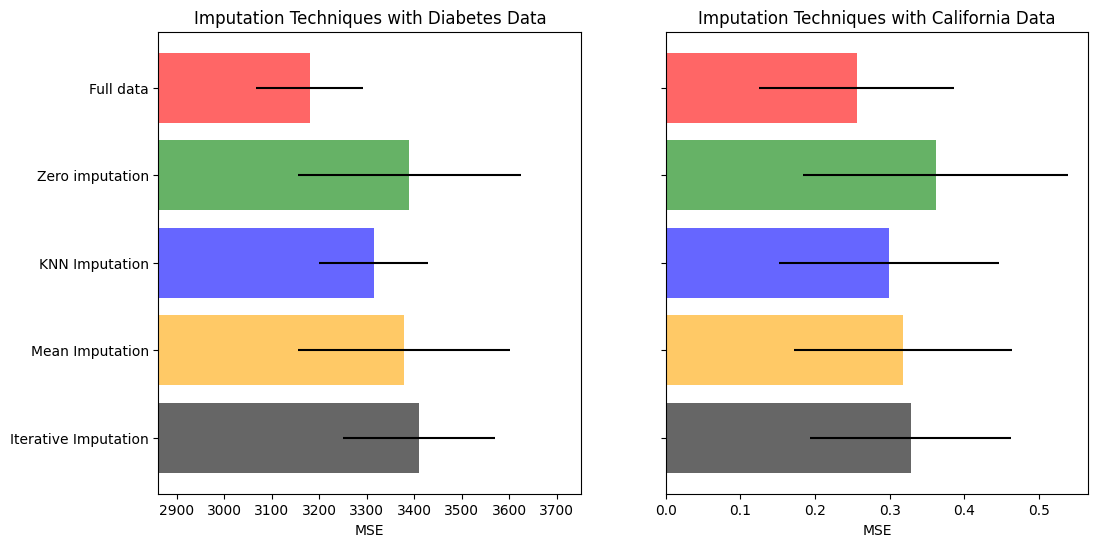

In [9]:
import matplotlib.pyplot as plt


n_bars = len(mses_diabetes)
xval = np.arange(n_bars)

colors = ["r", "g", "b", "orange", "black"]

# plot diabetes results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
for j in xval:
    ax1.barh(
        j,
        mses_diabetes[j],
        xerr=stds_diabetes[j],
        color=colors[j],
        alpha=0.6,
        align="center",
    )

ax1.set_title("Imputation Techniques with Diabetes Data")
ax1.set_xlim(left=np.min(mses_diabetes) * 0.9, right=np.max(mses_diabetes) * 1.1)
ax1.set_yticks(xval)
ax1.set_xlabel("MSE")
ax1.invert_yaxis()
ax1.set_yticklabels(x_labels)

# plot california dataset results
ax2 = plt.subplot(122)
for j in xval:
    ax2.barh(
        j,
        mses_california[j],
        xerr=stds_california[j],
        color=colors[j],
        alpha=0.6,
        align="center",
    )

ax2.set_title("Imputation Techniques with California Data")
ax2.set_yticks(xval)
ax2.set_xlabel("MSE")
ax2.invert_yaxis()
ax2.set_yticklabels([""] * n_bars)

plt.show()

Vous pouvez également essayer différentes techniques. Par exemple, la médiane est un estimateur plus robuste pour les données avec des variables de grande magnitude qui pourraient dominer les résultats (également connu sous le nom de "longue traîne").